In [39]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from utils.dataloader  import load_data
import time
from utils.confLoader import *
from models.qcModel import Quanv2D
import qsimcirq

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 16  # You can adjust this based on your needs

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:11<00:00, 853882.39it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1305862.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:03<00:00, 530873.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 38563823.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

# Example of moving a tensor to the specified device
tensor = torch.tensor([1.0, 2.0, 3.0])
tensor = tensor.to(device)

cuda


In [40]:
class SimpleModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.simulator = qsimcirq.QSimSimulator()
        self.features = nn.Sequential(
            Quanv2D(self.simulator, 1, 28, kernel_size=2, stride = 1), # 27*27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2), #13*13
            nn.Conv2d(28, 196, kernel_size=2, stride = 1), #10*10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride = 2), #6*6
        )
        
        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(6*6))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=196*6*6, out_features=250, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=250, out_features=10, bias=True)
        )
        
        self.overall = nn.Sequential(             
            self.features,
            self.avgpool,
            self.classifier
        )
        
        def backward(self, *args, **kwargs):
            print("Custom backward function called")
            super().backward(*args, **kwargs)
        
    def forward(self, xb):
        self.out = self.overall(xb)
        return self.out
    

In [41]:
model = SimpleModel()
model = model.to(device)
print(model)

SimpleModel(
  (features): Sequential(
    (0): Quanv2D( 1, 28, kernel =(2,2) stride =(1, 1), precision=10 )
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(28, 196, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): Sequential(
    (0): AdaptiveAvgPool2d(output_size=36)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7056, out_features=250, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=250, out_features=10, bias=True)
  )
  (overall): Sequential(
    (0): Sequential(
      (0): Quanv2D( 1, 28, kernel =(2,2) stride =(1, 1), precision=10 )
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(28, 196, kerne

In [42]:
# model = model.to(device)
total_loss = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
total_image  = 0
for epoch in range(100):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        total_image += inputs.shape[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if total_image > 300 : break
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    

False


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

: 

In [37]:
print(total_image)

1888


In [38]:
total = 0
correct = 0
num_images = 0
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    # print(outputs, labels)
    correct += (predicted == labels).sum().item()
    num_images += inputs.size(0)
    if num_images > 100: break
    # print(f"total: {total}, correct = {correct}")
print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 112 test images: 62.50%


In [4]:
from train import Trainner
from models.model_v2 import RetinopathyClassification
import torch.multiprocessing as mp

total: 4, correct = 0
total: 8, correct = 1
total: 12, correct = 5
total: 16, correct = 6
total: 20, correct = 9
total: 24, correct = 11
total: 28, correct = 12
total: 32, correct = 12
total: 36, correct = 13
total: 40, correct = 13
total: 44, correct = 13
total: 48, correct = 14
total: 52, correct = 16
total: 56, correct = 16
total: 60, correct = 17
total: 64, correct = 17
total: 68, correct = 19
total: 72, correct = 20
total: 76, correct = 21
total: 80, correct = 22
total: 84, correct = 26
total: 88, correct = 28
total: 92, correct = 30
total: 96, correct = 30
total: 100, correct = 31
Accuracy of the network on the 100 test images: 31.00%
tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 

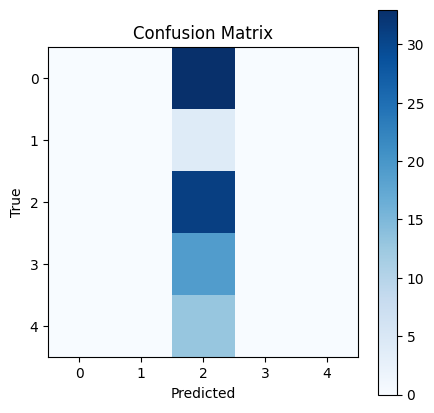

: 

In [5]:
mp.set_start_method('spawn')
model = RetinopathyClassification()
# print(model)
trainer = Trainner(model, 20)
trainer.loadModel("model_classic_v2.5")
# trainer.train()
# trainer.save("model_resnet_v1.3")
# trainer.test()
trainer.conf_mat()

In [1]:
import qiskit
from qiskit_aer import AerSimulator

In [19]:
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
# from qiskit.providers.fake_provider import FakeManilaV2

In [20]:
def kernel(P, W):
    qreg_q = QuantumRegister(6, 'q')
    creg_c = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    for i in range(1,5):
        circuit.ry(pi * P[i-1], qreg_q[i])

    for i in range(4):
        circuit.rx(pi * W[i], qreg_q[0])
        circuit.ccx(qreg_q[0], qreg_q[i+1], qreg_q[5])

    circuit.measure(qreg_q[5], creg_c[0])

    return circuit

In [26]:
# circ = kernel([0.3,0.2,0.1,0.0],[0.3,0.8,0.9,0.2])
# aersim = AerSimulator()
# backend = FakeManilaV2()
# backend = AerSimulator.from_backend(backend)
backend = AerSimulator(device = 'GPU', method = "State Vector")
# simulator = qsimcirq.QSimSimulator()
import time

In [27]:
def loading_bar( current_value, total_value, bar_length=40):
    progress = min(1.0, current_value / total_value)
    arrow = '■' * int(progress * bar_length)
    spaces = ' ' * (bar_length - len(arrow))
    print(f'\r[{arrow}{spaces}] {int(progress * 100)}%', end='', flush=True)

In [28]:
def runner():
    for i in range(28*28):
        circ = kernel([0.3,0.2,0.1,0.0],[0.3,0.8,0.9,0.2])
        qc_compiled = transpile(circ, backend)
        job_sim = backend.run(qc_compiled, shots=1024)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc_compiled)
        loading_bar(i, 28*28)

In [29]:
then = time.time()
runner()
delta = time.time() - then
print(f"Image processed in: {delta: .6f}sec") 

RuntimeError: Simulation device "GPU" is not supported on this system